In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [2]:
dataset = pd.read_csv('../../../datasets/sp_500_stocks/sp500_stocks.csv') #, nrows=1000000)

In [3]:
dataset = dataset.dropna()
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
22524,2010-01-04,AMD,9.700000,9.700000,9.900000,9.680000,9.790000,18748700.0
22525,2010-01-05,AMD,9.710000,9.710000,9.900000,9.680000,9.710000,22145700.0
22526,2010-01-06,AMD,9.570000,9.570000,9.760000,9.550000,9.680000,18643400.0
22527,2010-01-07,AMD,9.470000,9.470000,9.550000,9.180000,9.510000,26806800.0
22528,2010-01-08,AMD,9.430000,9.430000,9.470000,9.290000,9.370000,13752800.0
...,...,...,...,...,...,...,...,...
1880749,2024-11-25,ZBRA,400.940002,400.940002,404.320007,398.130005,400.029999,420200.0
1880750,2024-11-26,ZBRA,402.450012,402.450012,403.570007,399.690002,402.440002,369200.0
1880751,2024-11-27,ZBRA,405.750000,405.750000,406.140015,400.929993,403.730011,258300.0
1880752,2024-11-29,ZBRA,407.000000,407.000000,409.029999,405.510010,406.640015,175700.0


In [4]:
# dataset = dataset.loc[(dataset['Symbol'] == "AAPL") | (dataset['Symbol'] == "JNJ") | (dataset['Symbol'] == "JPM") | (dataset['Symbol'] == "XOM") | (dataset['Symbol'] == "PG") | (dataset['Symbol'] == "HD") | (dataset['Symbol'] == "T") | (dataset['Symbol'] == "UNP") | (dataset['Symbol'] == "DUK") | (dataset['Symbol'] == "AMT") | (dataset['Symbol'] == "MDLZ")]
ticker = "AMT"
companyName = "American Tower Corp"
dataset = dataset.loc[(dataset['Symbol'] == "AMT")]

In [5]:
dataset = dataset.sort_values("Date")
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
108866,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0
108867,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0
108868,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0
108869,2010-01-07,AMT,33.818180,44.290001,44.570000,44.009998,44.430000,2615000.0
108870,2010-01-08,AMT,33.886909,44.380001,44.570000,44.009998,44.380001,1934600.0
...,...,...,...,...,...,...,...,...
112615,2024-11-25,AMT,207.550003,207.550003,208.039993,204.699997,205.470001,3605900.0
112616,2024-11-26,AMT,208.000000,208.000000,208.830002,205.369995,206.570007,1791400.0
112617,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0
112618,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0


In [6]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
dataset = dataset.drop(columns=['Adj Close', "Volume", "Close", "Open", "Low", "High"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1

dataset

,Date,Symbol,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber
108866,2010-01-04,AMT,733776,43.584999,0,1,2010,4,1,0,0,1,0,1
108867,2010-01-05,AMT,733777,43.825001,1,1,2010,5,1,0,0,1,0,2
108868,2010-01-06,AMT,733778,44.165001,2,1,2010,6,1,0,0,1,0,3
108869,2010-01-07,AMT,733779,44.289999,3,1,2010,7,1,0,0,1,0,4
108870,2010-01-08,AMT,733780,44.289999,4,1,2010,8,1,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112615,2024-11-25,AMT,739215,206.369995,0,11,2024,330,48,0,0,4,3,5440
112616,2024-11-26,AMT,739216,207.099998,1,11,2024,331,48,0,0,4,3,5441
112617,2024-11-27,AMT,739217,208.750000,2,11,2024,332,48,0,0,4,3,5442
112618,2024-11-29,AMT,739219,208.650002,4,11,2024,334,48,0,0,4,3,5444


In [7]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
dataset.reset_index(drop=True, inplace=True)
dataset

,Date,Symbol,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber
0,2010-01-04,0,733776,43.584999,0,1,2010,4,1,0,0,1,0,1
1,2010-01-05,0,733777,43.825001,1,1,2010,5,1,0,0,1,0,2
2,2010-01-06,0,733778,44.165001,2,1,2010,6,1,0,0,1,0,3
3,2010-01-07,0,733779,44.289999,3,1,2010,7,1,0,0,1,0,4
4,2010-01-08,0,733780,44.289999,4,1,2010,8,1,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,2024-11-25,0,739215,206.369995,0,11,2024,330,48,0,0,4,3,5440
3750,2024-11-26,0,739216,207.099998,1,11,2024,331,48,0,0,4,3,5441
3751,2024-11-27,0,739217,208.750000,2,11,2024,332,48,0,0,4,3,5442
3752,2024-11-29,0,739219,208.650002,4,11,2024,334,48,0,0,4,3,5444


In [8]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(dataset[['DateOrdinal', 'average_price']])
normalized_dataset = pd.DataFrame(scaled_data)
normalized_dataset["Date"] = dataset["Date"]
normalized_dataset["DateOrdinal"] = normalized_dataset[0]
normalized_dataset["average_price"] = normalized_dataset[1]

normalized_dataset = normalized_dataset.drop(columns=[0, 1])

normalized_dataset

,Date,DateOrdinal,average_price
0,2010-01-04,0.000000,0.017347
1,2010-01-05,0.000184,0.018263
2,2010-01-06,0.000367,0.019561
3,2010-01-07,0.000551,0.020038
4,2010-01-08,0.000734,0.020038
...,...,...,...
3749,2024-11-25,0.998715,0.638652
3750,2024-11-26,0.998898,0.641438
3751,2024-11-27,0.999082,0.647736
3752,2024-11-29,0.999449,0.647354


In [9]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [10]:
# aux = dataset.copy()
#
# X = aux[['Date', 'Symbol']].copy()
# aux = aux.drop(['Date', 'Symbol'], axis=1)
#
# Y = aux.copy()
#
# X_train = X.iloc[:trainSamples]
# Y_train = Y.iloc[:trainSamples]
# X_test = X.iloc[-testSamples:]
# Y_test = Y.iloc[-testSamples:]
#
# X_train

In [11]:
blockSizes = [300, 500, 1000, 3000, 4000]
algorithmList = ["RFTS_Non_Overlapping", "RFTS_MovingBlock", "RFTS_CircularBlock"]
dayTimeWindows = [1825, 730, 365, 180, 30]

symbols = dataset['Symbol'].nunique()
dataset["Symbol"] = dataset["Symbol"] + 1

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def comparativeGraph(y_test, y_pred, timeLinePred, regressorName):


    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.plot(timeLinePred["Date"], y_pred, color='red')
    plt.plot(timeLinePred["Date"], y_test, color='blue')
    plt.title(regressorName)
    plt.show()
    return

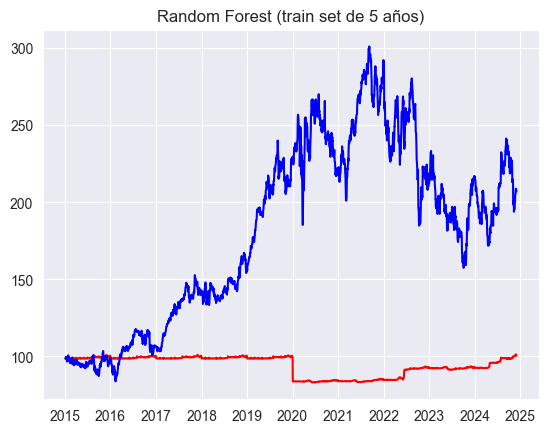

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import datetime
import random

totalRows = dataset.shape[0]

# for blockSize in blockSizes:
#
#     for algorithm in algorithmList:
#
# dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
# dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
# dataset['quarter'] = dataset['Date'].dt.quarter
# dataset['season'] = dataset['Month'].apply(get_season)
for days in [1825]:#[1825]:#dayTimeWindows:

    rowIdx = 0# random.randint(0, (totalRows - int(days * 1.3) // symbols))
    initDate = dataset.values[rowIdx][0]
    endDate = initDate + datetime.timedelta(days=days)
    daysInRange = 10 * 365 + 1
    cicleStart = pd.Timestamp(initDate)

    dataset0 = dataset.copy()
    dataset0['DaysInCicle'] = (dataset0['Date'] - cicleStart).dt.days
    dataset0['DaysIn5Years'] = (dataset0['DaysInCicle'] % daysInRange) + 1

    trainSamples = dataset0[(dataset0['Date'] >= initDate) & (dataset0['Date'] < endDate)]
    testSamples = dataset0[(dataset0['Date'] >= endDate)]

    aux = trainSamples.copy()
    X_train = aux[['DateOrdinal', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'DaysInCicle', 'DaysIn5Years', 'SerieNumber']].copy()
    aux = aux.drop(['Date', 'DateOrdinal', 'Symbol', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'DaysInCicle', 'DaysIn5Years', 'SerieNumber'], axis=1)
    Y_train = aux.copy().values.ravel()
    aux0 = testSamples.copy()
    X_test = aux0[['DateOrdinal', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'DaysInCicle', 'DaysIn5Years', 'SerieNumber']].copy()
    timeLinePred = aux0[['DateOrdinal', 'Date']].copy()
    aux0 = aux0.drop(['Date', 'DateOrdinal', 'Symbol', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'DaysInCicle', 'DaysIn5Years', 'SerieNumber'], axis=1)
    Y_test = aux0.copy().values.ravel()


    basicRF = RandomForestRegressor(n_jobs=100, n_estimators=500, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)

    comparativeGraph(Y_test, y_pred, timeLinePred, "Random Forest (train set de 5 años)")

In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [15]:
# for days in [1825]:#dayTimeWindows:
#
#     rowIdx = 0# random.randint(0, (totalRows - int(days * 1.3) // symbols))
#     initDate = dataset.values[rowIdx][0]
#     endDate = initDate + datetime.timedelta(days=days)
#
#     trainSamples = dataset[(dataset['Date'] >= initDate) & (dataset['Date'] < endDate)]
#     testSamples = dataset[(dataset['Date'] >= endDate)]
#
#     aux = trainSamples.copy()
#     X_train = aux[['DateOrdinal']].copy()
#     aux = aux.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_train = aux.copy().values.ravel()
#     aux0 = testSamples.copy()
#     X_test = aux0[['DateOrdinal']].copy()
#     timeLinePred = aux0[['DateOrdinal', 'Date']].copy()
#     aux0 = aux0.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_test = aux0.copy().values.ravel()
#
#
#     basicRF = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSizes[0])
#     basicRF.fit(X_train, Y_train)
#     y_pred = basicRF.predict(X_test)
#
#     comparativeGraph(Y_test, y_pred, timeLinePred, f"RFTS Non-Overlapping (BlockSize: {blockSizes[0]}, train set de 5 años)")

In [16]:
# for days in [1825]:#dayTimeWindows:
#
#     rowIdx = 0# random.randint(0, (totalRows - int(days * 1.3) // symbols))
#     initDate = dataset.values[rowIdx][0]
#     endDate = initDate + datetime.timedelta(days=days)
#
#     trainSamples = dataset[(dataset['Date'] >= initDate) & (dataset['Date'] < endDate)]
#     testSamples = dataset[(dataset['Date'] >= endDate)]
#
#     aux = trainSamples.copy()
#     X_train = aux[['DateOrdinal']].copy()
#     aux = aux.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_train = aux.copy().values.ravel()
#     aux0 = testSamples.copy()
#     X_test = aux0[['DateOrdinal']].copy()
#     timeLinePred = aux0[['DateOrdinal', 'Date']].copy()
#     aux0 = aux0.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_test = aux0.copy().values.ravel()
#
#
#     basicRF = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSizes[1])
#     basicRF.fit(X_train, Y_train)
#     y_pred = basicRF.predict(X_test)
#
#     comparativeGraph(Y_test, y_pred, timeLinePred, f"RFTS MovingBlock (BlockSize: {blockSizes[1]}, train set de 5 años)")

In [17]:
# for days in [3650]:#dayTimeWindows:
#
#     rowIdx = 0# random.randint(0, (totalRows - int(days * 1.3) // symbols))
#     initDate = dataset.values[rowIdx][0]
#     endDate = initDate + datetime.timedelta(days=days)
#
#     trainSamples = dataset[(dataset['Date'] >= initDate) & (dataset['Date'] < endDate)]
#     testSamples = dataset[(dataset['Date'] >= endDate)]
#
#     aux = trainSamples.copy()
#     X_train = aux[['DateOrdinal']].copy()
#     aux = aux.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_train = aux.copy().values.ravel()
#     aux0 = testSamples.copy()
#     X_test = aux0[['DateOrdinal']].copy()
#     timeLinePred = aux0[['DateOrdinal', 'Date']].copy()
#     aux0 = aux0.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
#     Y_test = aux0.copy().values.ravel()
#
#
#     basicRF = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSizes[2])
#     basicRF.fit(X_train, Y_train)
#     y_pred = basicRF.predict(X_test)
#
#     comparativeGraph(Y_test, y_pred, timeLinePred, f"RFTS CircularBlock (BlockSize: {blockSizes[2]}, train set de 5 años)")

In [18]:
# dataset

In [19]:
def predict(daysList, algorithm="", blockSize=1, daysOfPredictions=0):
    for days0 in daysList:

        rowIdx0 = 0# random.randint(0, (totalRows - int(days * 1.3) // symbols))
        initDate0 = dataset.values[rowIdx0][0]
        endDate0 = initDate + datetime.timedelta(days=days0)

        dataset00 = dataset.copy()
        #dataset00['DaysInCicle'] = (dataset00['Date'] - cicleStart).dt.days
        #dataset00['DaysIn5Years'] = (dataset00['DaysInCicle'] % daysInRange) + 1

        trainSamples0 = dataset00[(dataset['Date'] >= initDate0) & (dataset00['Date'] < endDate0)]
        if daysOfPredictions <= 0:
            testSamples0 = dataset00[(dataset['Date'] >= endDate0)]
        else:
            endDateTest = endDate0 + datetime.timedelta(days=daysOfPredictions)
            testSamples0 = dataset00[(dataset['Date'] >= endDate0) & (dataset00['Date'] < endDateTest)]

        aux00 = trainSamples0.copy()
        X_train0 = aux00[['DateOrdinal', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'SerieNumber']].copy()
        aux00 = aux00.drop(['Date', 'DateOrdinal', 'Symbol', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'SerieNumber'], axis=1)
        Y_train0 = aux00.copy().values.ravel()
        aux01 = testSamples0.copy()
        X_test0 = aux01[['DateOrdinal', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'SerieNumber']].copy()
        timeLinePred0 = aux01[['DateOrdinal', 'Date']].copy()
        aux01 = aux01.drop(['Date', 'DateOrdinal', 'Symbol', 'Month', 'Year', 'DayOfYear', 'DayOfWeek', 'WeekOfYear', 'is_start_of_month', 'is_end_of_month', 'quarter', 'season', 'SerieNumber'], axis=1)
        Y_test0 = aux01.copy().values.ravel()
        # aux00 = trainSamples0.copy()
        # X_train0 = aux00[['DateOrdinal']].copy()
        # aux00 = aux00.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
        # Y_train0 = aux00.copy().values.ravel()
        # aux01 = testSamples0.copy()
        # X_test0 = aux01[['DateOrdinal']].copy()
        # timeLinePred0 = aux01[['DateOrdinal', 'Date']].copy()
        # aux01 = aux01.drop(['Date', 'DateOrdinal', 'Symbol'], axis=1)
        #Y_test0 = aux01.copy().values.ravel()

        if algorithm == 'NonOverlapping':
            basicRF0 = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSize)
        else:
            if algorithm == 'MovingBlock':
                basicRF0 = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSize, block_type=BLOCK_TYPES[1])
            else:
                if algorithm == 'CircularBlock':
                    basicRF0 = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, max_depth=10, block_size=blockSize, block_type=BLOCK_TYPES[2])
                else:
                    blockSize = 1
                    algorithm = "Random Forest"
                    basicRF0 = RandomForestRegressor(n_jobs=100, n_estimators=500, max_depth=10)
        basicRF0.fit(X_train0, Y_train0)
        y_pred0 = basicRF0.predict(X_test0)
        #print(y_pred0)
        comparativeGraph(Y_test0, y_pred0, timeLinePred0, f"RFTS {algorithm}, Ticker: {ticker}({companyName}) (BlockSize: {blockSize}, train set de {days0} días)")

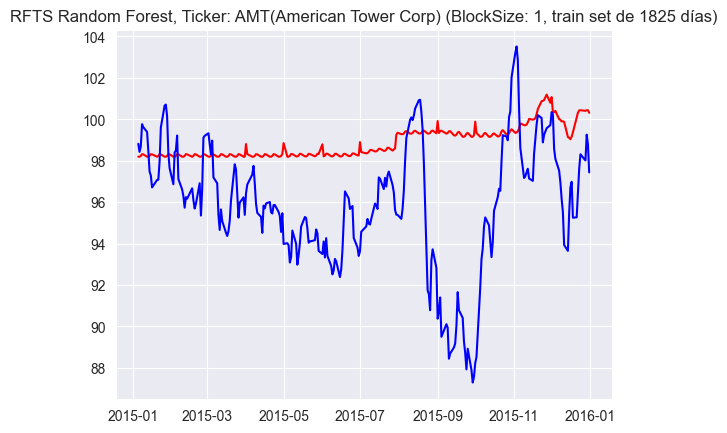

In [20]:
predict([1825], daysOfPredictions=365)

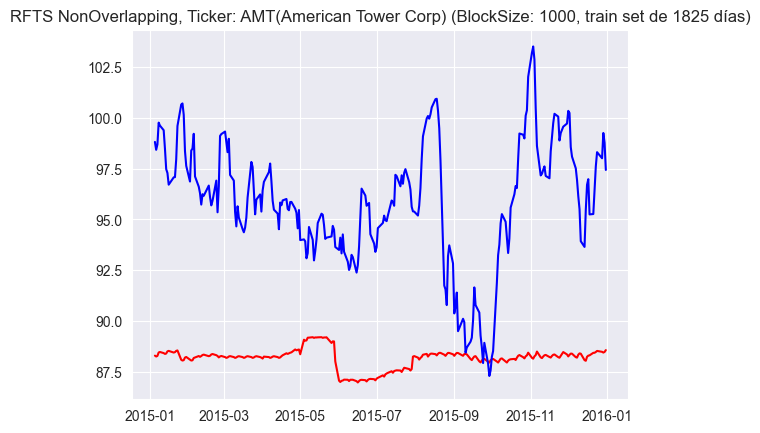

In [21]:
predict([1825], "NonOverlapping", 1000, 365)

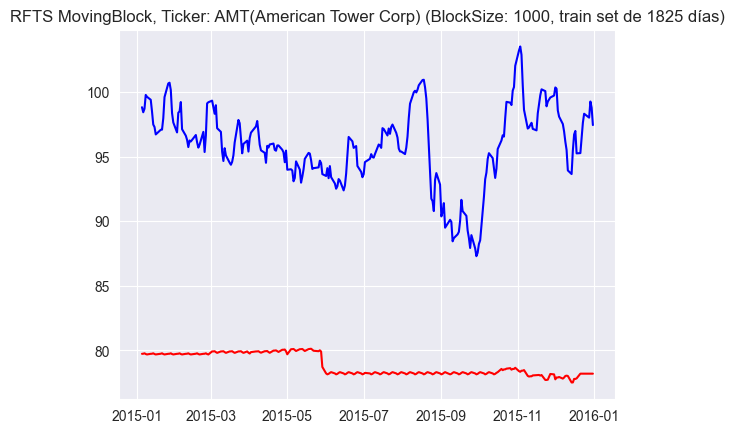

In [22]:
predict([1825], "MovingBlock", 1000, 365)

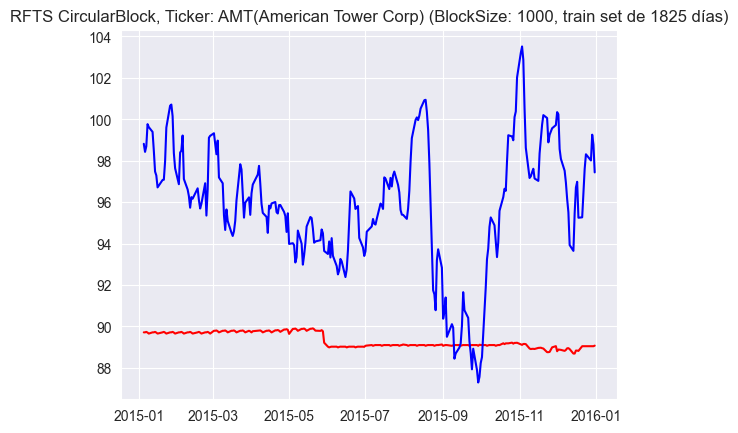

In [23]:
predict([1825], "CircularBlock", 1000, 365)

In [25]:
predict([1000], "NonOverlapping", 1000, 365)

ValueError: cannot convert float NaN to integer